In [ ]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
import os
import glob
import trimesh
import numpy as np
from tensorflow import data as tf_data
from keras import ops
import keras
from keras import layers
from matplotlib import pyplot as plt

keras.utils.set_random_seed(seed=42)

In [ ]:
DATA_DIR = keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

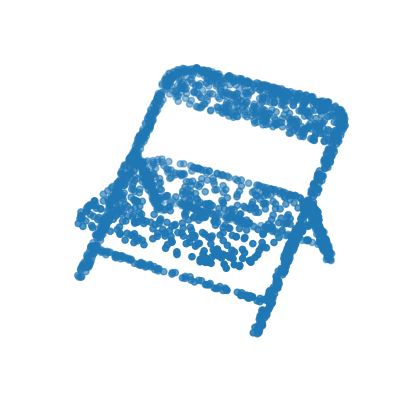

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("Processando classe: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return(
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

Processando classe: night_stand
Processando classe: bathtub
Processando classe: chair
Processando classe: table
Processando classe: bed
Processando classe: toilet
Processando classe: monitor
Processando classe: desk
Processando classe: dresser
Processando classe: sofa


In [ ]:
def augment(points, label):
    points += keras.random.uniform(points.shape, -0.005, 0.005, dtype = "float64")
    points = keras.random.shuffle(points)
    return points, label


train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = ops.eye(num_features)

    def __call__(self, x):
        x = ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = ops.tensordot(x, x, axes=(2, 2))
        xxt = ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return ops.sum(self.l2reg * ops.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2048, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 2048, 32)       │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048, 32)       │            128 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 2048, 32)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 2048, 64)       │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048, 64)       │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 2048, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 2048, 512)      │         33,280 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 2048, 512)      │          2,048 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 2048, 512)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 512)            │              0 │ activation_2[0][0]     │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256)            │          1,024 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 748,979 (2.86 MB)

 Trainable params: 742,899 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=25, validation_data=validation_dataset)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - loss: 45.3608 - sparse_categorical_accuracy: 0.2254 - val_loss: 16546641477632.0000 - val_sparse_categorical_accuracy: 0.3492
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 36.3232 - sparse_categorical_accuracy: 0.3100 - val_loss: 509383911579582464.0000 - val_sparse_categorical_accuracy: 0.4230
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 36.0716 - sparse_categorical_accuracy: 0.3410 - val_loss: 48809951188790280192.0000 - val_sparse_categorical_accuracy: 0.4255
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 35.9978 - sparse_categorical_accuracy: 0.3655 - val_loss: 830405754224640.0000 - val_sparse_categorical_accuracy: 0.4443
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 35.8362 - sparse_categorical_accuracy: 0.3840 - val_loss: 1076379470790656.0000 - val_sparse_categorical_accuracy: 0.5044
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 35.7702 - sparse_

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


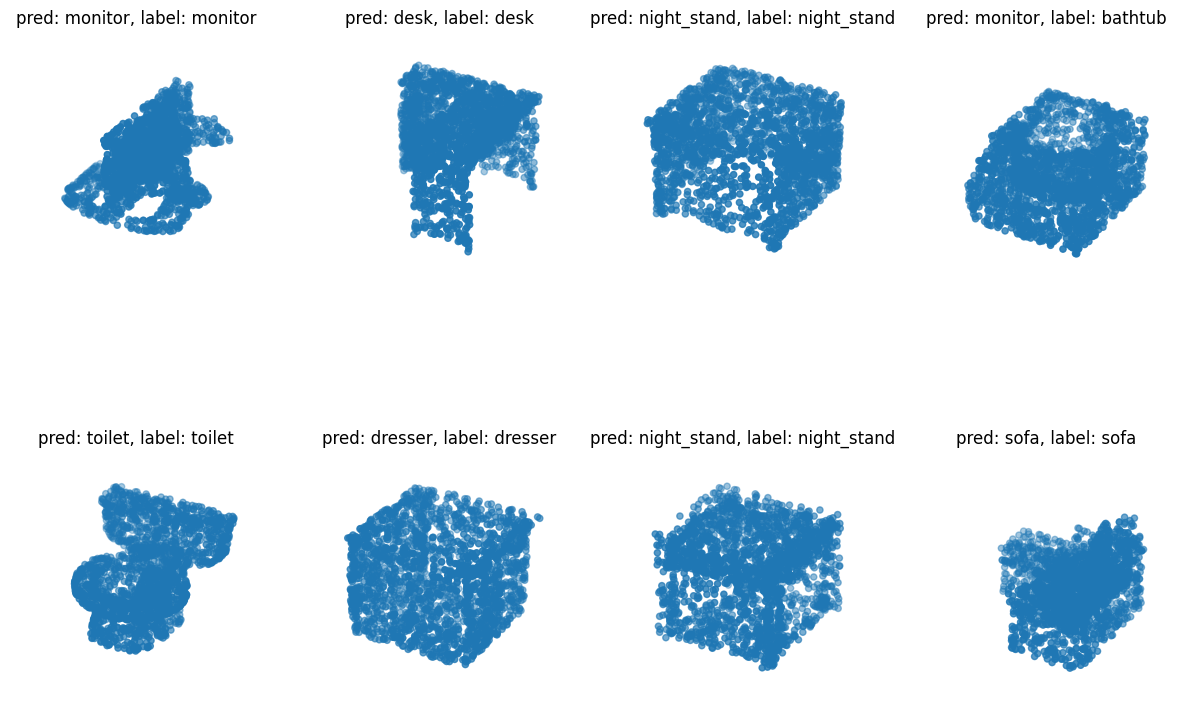

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()

fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()